In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.colors import LogNorm
import unidecode

import matplotlib as mpl
font = {        'size'   : 15}
mpl.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats

In [2]:
# Getting the top 19 cities
iwiw_codes = [379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 396, 1842, 2103]
iwiw_code_dict= {379: 'Budapest', 380: 'Debrecen', 381: 'Miskolc', 382: 'Szeged', 383: 'Pecs', 384: 'Gyor', 385: 'Nyiregyhaza', 386: 'Kecskemet',
 387: 'Szekesfehervar', 388: 'Szombathely', 389: 'Szolnok', 390: 'Tatabanya', 391: 'Kaposvar', 392: 'Bekescsaba', 393: 'Zalaegerszeg',
 394: 'Veszprem', 396: 'Eger', 1842: 'Szekszard', 2103: 'Salgotarjan'}
city_to_code = {v:k for k,v in iwiw_code_dict.items()}

# useful masks
mask_SL_t = ~np.eye(18,dtype=bool) # mask for self loops in a snapshot
mask_SL = np.array([mask_SL_t]*11) # mask for self loops across all snapshots

In [3]:
def remove_accent(df):
    # input is the reduced df where all values are strings
    return df.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8'))

def names_to_ids(df):
    # input is the reduced df where all values are strings
    return df.apply(lambda x: x.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')).applymap(lambda x: city_to_code[x])

def users_per_city(W):
    n = np.zeros([W.shape[0],W.shape[1]],dtype='int')
    for t in range(W.shape[0]):
        n[t,:] = np.sum(W[0,:,:],axis=1) + np.sum(W[0:t+1,:,:],axis=(0,2))
    n[n==0]+=1 # artificially ensuring no cities have 0 users!
    return n  

In [4]:
shortest_paths = pd.read_csv('../simplified_roads/hungary/data/shortest_paths.csv')
shortest_paths[['source','target']]=names_to_ids(shortest_paths[['source','target']])
shortest_paths.head()

,year,source,target,travel_time,length
0,2002,383,1842,0.731910,59481.909
1,2002,383,391,1.128973,66148.099
2,2002,383,396,3.580360,325694.283
3,2002,383,380,4.809780,402441.212
4,2002,383,382,2.570852,188892.523


In [5]:
Years=shortest_paths['year'].unique()

In [6]:
graphs = {y:nx.from_pandas_edgelist(shortest_paths[shortest_paths['year']==y],
                                    source='source',target='target',edge_attr=['travel_time','length']) 
          for y in Years}

In [48]:
travel_time_adj_2002 = nx.to_numpy_array(graphs[2002],dtype=np.float32,weight='travel_time')

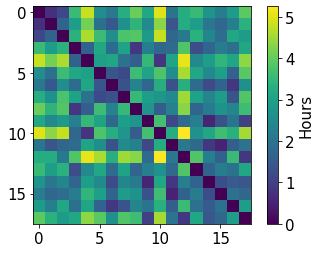

In [53]:
plt.imshow(travel_time_adj_2002)
plt.colorbar(label='Hours')

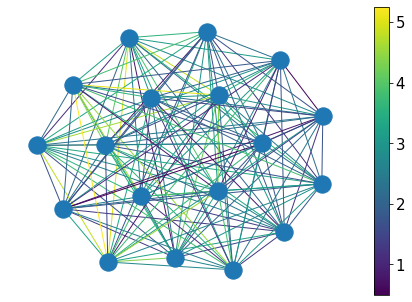

In [43]:
travel_time = [graphs[2002][u][v]['travel_time'] for u,v in graphs[2002].edges]
cmap = plt.cm.viridis
vmin = min(travel_time)
vmax = max(travel_time)
nx.draw(graphs[2002],edge_color=travel_time,edge_cmap=cmap,vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
plt.colorbar(sm)

In [7]:
travel_time_tensor = np.array([nx.to_numpy_array(graphs[y],dtype=np.float32,weight='travel_time') for y in Years])
length_tensor = np.array([nx.to_numpy_array(graphs[y],dtype=np.float32,weight='length') for y in Years])

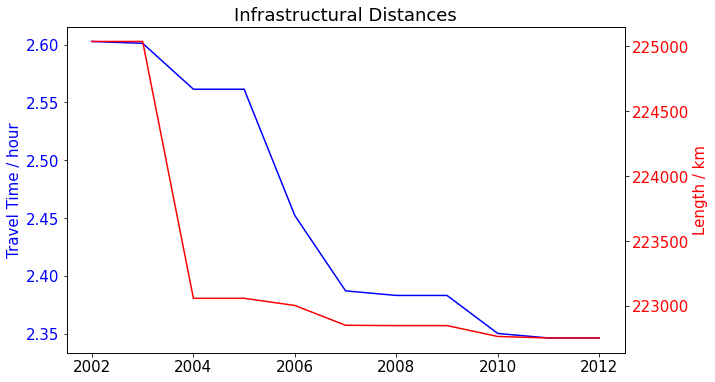

In [8]:
fig,axs=plt.subplots(figsize=(10,6),nrows=1)
axs.set_title("Infrastructural Distances")
color='blue'
axs.plot(Years,[travel_time_tensor[t,:,:][mask_SL_t].mean() for t in range(travel_time_tensor.shape[0])],color=color)
axs.set_ylabel("Travel Time / hour",color=color)
axs.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2 = axs.twinx()
ax2.plot(Years,[length_tensor[t,:,:][mask_SL_t].mean() for t in range(length_tensor.shape[0])],color=color)
ax2.set_ylabel("Length / km",color=color)
ax2.tick_params(axis='y', labelcolor=color)

# fig.savefig('../analysis/Figures/mean_infrastructural_distances.png',bbox_inches='tight')

# Reading social data

In [9]:
connections = pd.read_csv('../analysis/all_spatiosocial_data.csv')
graphs_S = {y:nx.from_pandas_edgelist(connections[connections['Year']==y],
                                    source='CityID_From',target='CityID_To',edge_attr='Connections') 
          for y in Years}

# removing Budapest
for y in Years:
    graphs_S[y].remove_node(389)
S = np.array([nx.to_numpy_array(graphs_S[y],dtype=np.float32,weight='Connections') for y in Years])

In [55]:
invitations_iwiw = pd.read_csv('../data/invitation_counts.csv.gz')
mask1 = invitations_iwiw["CityId"].map(lambda i: i in iwiw_codes)
mask2 = invitations_iwiw["InvitorCityId"].map(lambda i: i in iwiw_codes)
reduced_df = invitations_iwiw[mask1&mask2]
graphs_W = {year:nx.from_pandas_edgelist(reduced_df[reduced_df['RegYear']==year],
                                                        source='InvitorCityId',target='CityId',edge_attr='w',
                                                        create_using=nx.DiGraph)
            for year in Years}
# removing Budapest
for y in Years:
    graphs_W[y].remove_node(389)
# asymmetric, weighted tensor of size T x N x N
W = np.array([nx.to_numpy_array(graphs_W[y],dtype=np.float32,weight='w') for y in Years])
for i in range(W.shape[1]):
    W[:,i,i]=0

# Null Models

In [72]:
def gravity_model(dist,alpha=1,beta=1,gamma=2):
    return np.array([np.outer(n[t,:]**alpha,n[t,:]**beta)/(dist[t,:,:]**gamma) for t in range(n.shape[0])])

In [81]:
n = users_per_city(W)
mu = travel_time_tensor.mean(axis=(1,2))/n.mean(axis=1)**2

In [113]:
alpha = 1
beta = 1
gamma = 2
n=users_per_city(W) # natively two cities have 0 users to begin with
S_gravity_tt = gravity_model(travel_time_tensor,gamma=gamma)
S_gravity_l = gravity_model(length_tensor,gamma=gamma)

for i in range(S.shape[1]):
    S_gravity_tt[:,i,i]=0
    S_gravity_l[:,i,i]=0

/home/jbara/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [74]:
S_mean_t = [S[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])]
S_g_tt_mean_t = [S_gravity_tt[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])]
S_g_l_mean_t = [S_gravity_l[t,:,:][mask_SL_t].mean() for t in range(S.shape[0])]

print(S_mean_t)
print(S_g_tt_mean_t)

[2.130719, 7.2941175, 15.830066, 76.09804, 353.28104, 533.3137, 604.2222, 650.902, 685.817, 693.0458, 693.57513]
[196.9782559880929, 1068.9255946309438, 4167.299112212497, 86483.15688483034, 2483320.768245338, 5874812.804850371, 7682658.589492053, 8992623.349906417, 10365609.889488991, 10630738.978218013, 10647306.096890628]


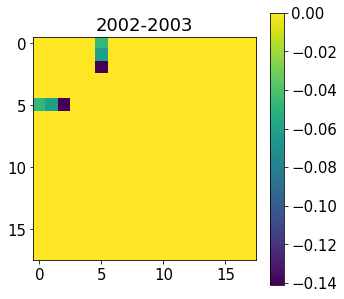

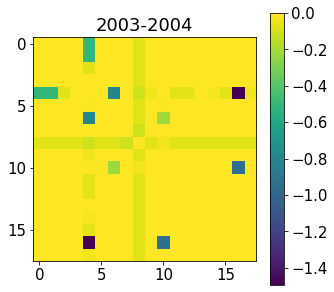

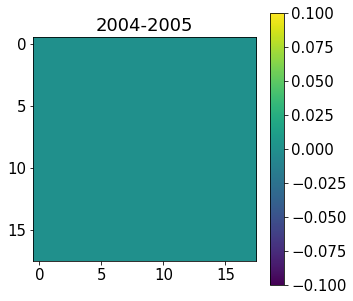

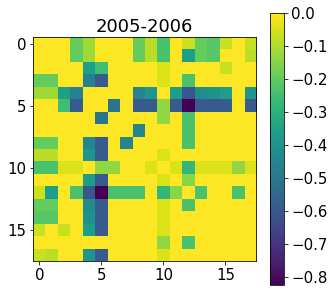

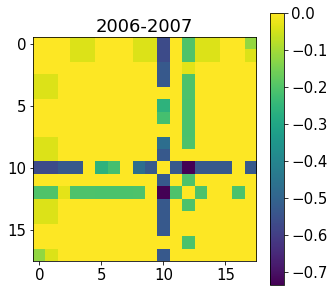

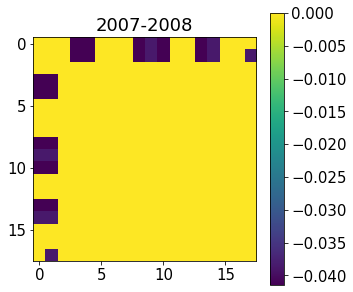

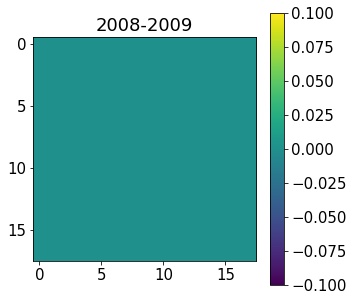

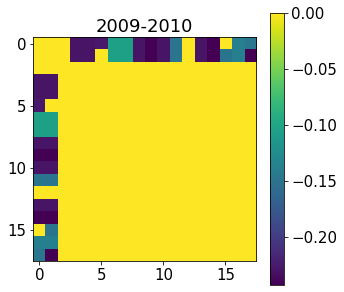

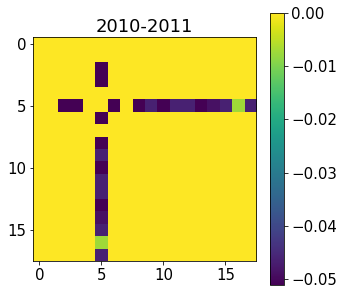

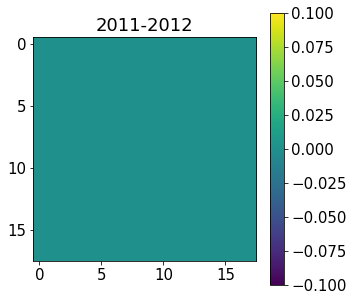

In [94]:
for t in range(S.shape[0]-1):
    plt.figure(figsize=(5,5))
    im=plt.imshow(np.diff(travel_time_tensor,axis=0)[t,:,:])#,
#                norm=LogNorm(vmin=D[D>0].min(),vmax=D.max()))
    plt.colorbar(im)
    title = str(Years[t])+'-'+str(Years[t+1])
    plt.title(title)

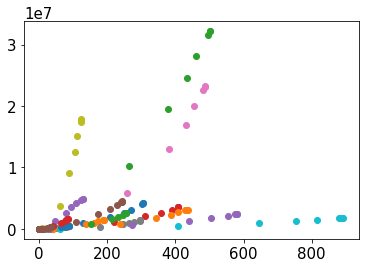

In [115]:
# plt.plot(Years,S[:,4,16])
# plt.plot(Years,S_gravity_tt[:,4,16])
# plt.plot(Years,S_gravity_l[:,4,16])

# plt.scatter(S_gravity_tt[mask_SL],S[mask_SL])

for j in range(1,S.shape[1]):
    if j != 4:
        plt.scatter(S[:,4,j],S_gravity_tt[:,4,j],label='4,'+str(j))
# plt.scatter(S_gravity_tt[:,4,0],S[:,4,0],label='(4,0)')
# plt.scatter(S_gravity_tt[:,4,0],S[:,4,10],label='(4,10)')
# plt.legend()
# plt.xscale('log')
# plt.yscale('log')

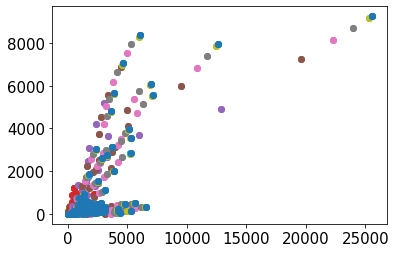

In [117]:
for t in range(S.shape[0]):
    plt.scatter(np.sqrt(S_gravity_tt[t,:,:]),S[t,:,:])
# plt.plot(np.linspace(0,S_gravity_tt[mask_SL].max()),np.linspace(0,S_gravity_tt[mask_SL].max()))
# plt.xscale('log')
# plt.yscale('log')

In [117]:
print(np.corrcoef(S[mask_SL],S_gravity_tt[mask_SL]))

[[1.        0.6448237]
 [0.6448237 1.       ]]
